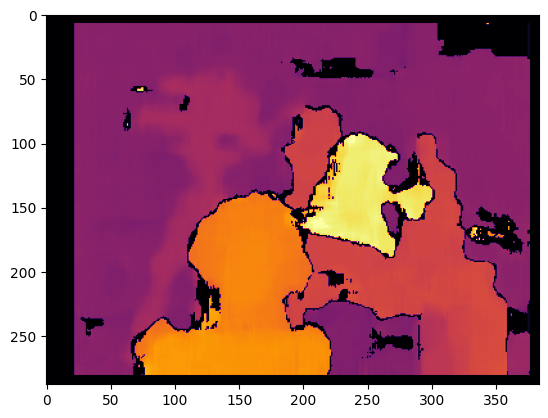

In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('./data/tsukuba_l.png',0)
imgR = cv2.imread('./data/tsukuba_r.png',0)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'inferno')
plt.show()

### Sum of Squared Differences(SSD)

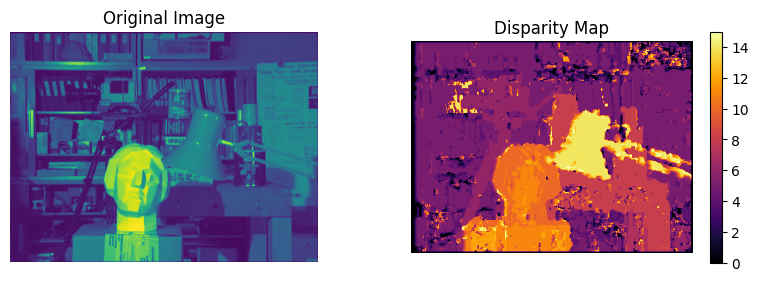

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def compute_disparity(imgL, imgR, num_disparities, block_size):
    # Ensure the images are numpy arrays
    imgL = np.asarray(imgL, dtype=np.float32)
    imgR = np.asarray(imgR, dtype=np.float32)
    
    # Image dimensions
    height, width = imgL.shape
    
    # Initialize the disparity map
    disparity_map = np.zeros((height, width), dtype=np.float32)
    
    # Half of the block size for easier indexing
    half_block = block_size // 2
    
    # Loop over each pixel in the left image
    for y in range(half_block, height - half_block):
        for x in range(half_block, width - half_block):
            # Define the block region in the left image
            blockL = imgL[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

            # Search range for disparities
            min_ssd = float('inf')
            best_disparity = 0
            for d in range(num_disparities):
                if x - d - half_block < 0:
                    continue
                # Define the block region in the right image
                blockR = imgR[y - half_block:y + half_block + 1, x - d - half_block:x - d + half_block + 1]

                # Compute the sum of squared differences (SSD)
                ssd = np.sum((blockL - blockR) ** 2)

                # Update the best disparity if needed
                if ssd < min_ssd:
                    min_ssd = ssd
                    best_disparity = d

            # Assign the best disparity to the disparity map
            disparity_map[y, x] = best_disparity

    return disparity_map

# Load grayscale images as numpy arrays
imgL = plt.imread('./data/tsukuba_l.png')
imgR = plt.imread('./data/tsukuba_r.png')

# Ensure the images are 2D arrays (grayscale)
if imgL.ndim == 3:
    imgL = imgL[:, :, 0]  # Convert to grayscale if needed
if imgR.ndim == 3:
    imgR = imgR[:, :, 0]  # Convert to grayscale if needed

# Parameters
num_disparities = 16
block_size = 5

# Compute disparity
disparity = compute_disparity(imgL, imgR, num_disparities, block_size)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.imshow(imgL)
plt.title('Original Image')
plt.axis("off")

# Display the disparity map
plt.subplot(1, 2, 2)
plt.imshow(disparity, cmap='inferno')
plt.colorbar()
plt.title('Disparity Map')
plt.axis("off")
plt.show()

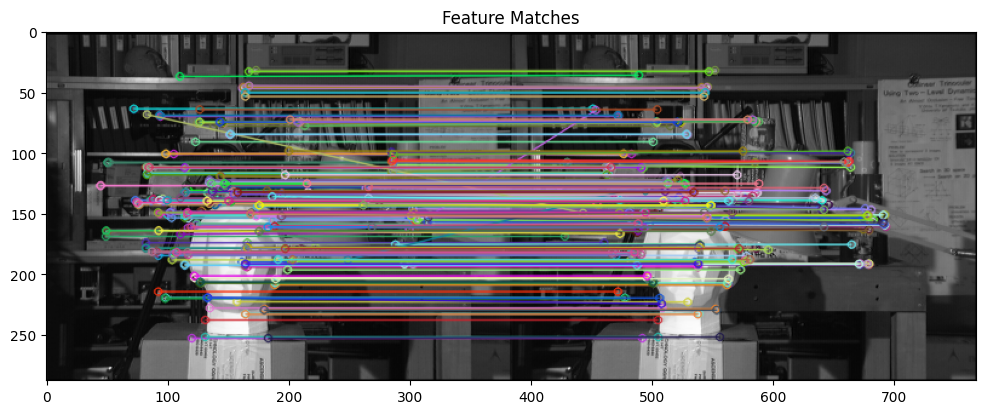

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Read the images (left and right images)
imgL = cv2.imread('./data/tsukuba_l.png', 0)  # Left image (grayscale)
imgR = cv2.imread('./data/tsukuba_r.png', 0)  # Right image (grayscale)

# Create ORB feature detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors for both images
kpL, desL = orb.detectAndCompute(imgL, None)  # Keypoints and descriptors for left image
kpR, desR = orb.detectAndCompute(imgR, None)  # Keypoints and descriptors for right image

# Create a brute-force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors between the left and right images
matches = bf.match(desL, desR)

# Visualize the matched keypoints
img_matches = cv2.drawMatches(imgL, kpL, imgR, kpR, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched keypoints
plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.title('Feature Matches')
plt.show()

Using cache found in /home/kar/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/kar/.cache/torch/hub/intel-isl_MiDaS_master


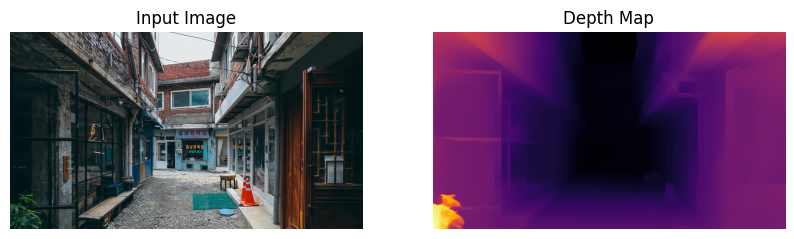

In [17]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load MiDaS model
model_type = "DPT_Large"  # Options: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# Load MiDaS transform
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform if model_type in ["DPT_Large", "DPT_Hybrid"] else midas_transforms.small_transform

# Load and preprocess the input image
input_image = cv2.imread("test.png")  # Replace with your image path
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

input_batch = transform(input_image).to(device)

# Perform depth estimation
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=input_image.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# Normalize the depth map for visualization
depth_map = prediction.cpu().numpy()
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(input_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Depth Map")
plt.imshow(depth_map, cmap="inferno")
plt.axis("off")

plt.show()

### Edge Detection

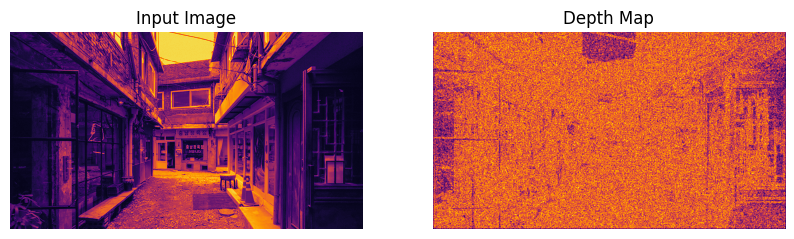

In [18]:
import numpy as np
import matplotlib.pyplot as plt  # Visualization library

# Input image generation (example uses a random grayscale image)
image_height, image_width = 100, 100  # Image dimensions

# 1. Convert to Grayscale
# Grayscale formula: 0.2989*R + 0.5870*G + 0.1140*B
gray_image = cv2.imread('test.png', 0)  # Load image in grayscale mode

# 2. Simple depth estimation (Edge-based Depth)
# Edge detection using Sobel filter (vertical and horizontal directions)
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # X-direction filter
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # Y-direction filter

# Perform convolution to calculate gradient magnitudes
depth_x = np.zeros_like(gray_image)  # Initialize gradient in X direction
depth_y = np.zeros_like(gray_image)  # Initialize gradient in Y direction

# Apply Sobel filters to calculate gradients
for i in range(1, gray_image.shape[0] - 1):
    for j in range(1, gray_image.shape[1] - 1):
        region = gray_image[i-1:i+2, j-1:j+2]  # Extract 3x3 region
        depth_x[i, j] = np.sum(region * sobel_x)  # Convolve with Sobel X
        depth_y[i, j] = np.sum(region * sobel_y)  # Convolve with Sobel Y

# 3. Compute the final depth map
# Combine horizontal and vertical gradients to compute magnitude
depth_map = np.sqrt(depth_x**2 + depth_y**2)

# 4. Normalize the depth map to range 0-1
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Visualize results
plt.figure(figsize=(10, 5))

# Display the input grayscale image
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(gray_image, cmap="inferno")
plt.axis("off")

# Display the computed depth map
plt.subplot(1, 2, 2)
plt.title("Depth Map")
plt.imshow(depth_map, cmap="inferno")
plt.axis("off")

plt.show()


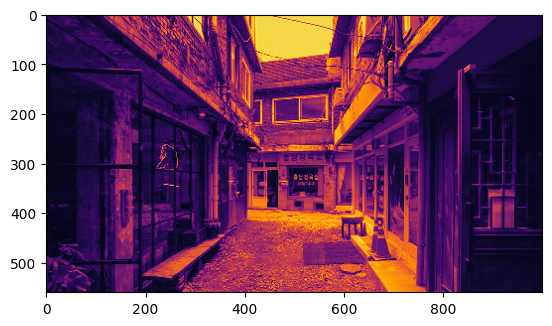

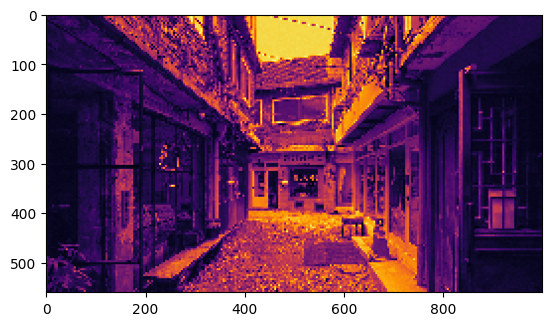

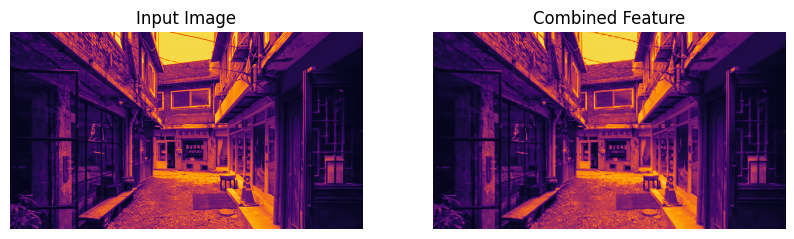

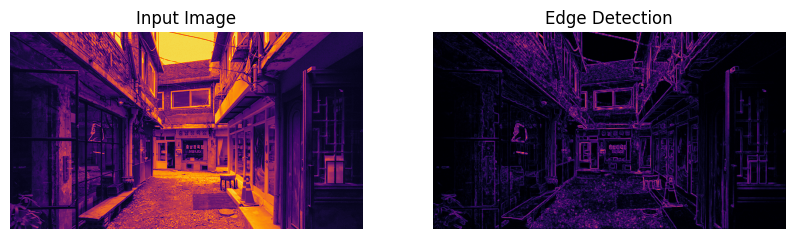

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load input image (example image used)
image_height, image_width = 100, 100

# 1. Convert to Grayscale
gray_image = cv2.imread('test.png', 0)  # Load image in grayscale mode

# 2. Multi-Scale Feature Extraction
def downsample(image, scale):
    """Reduce the size of an image by the given scale factor"""
    h, w = image.shape
    new_h, new_w = h // scale, w // scale
    return image[::scale, ::scale]

def upsample(image, original_shape):
    """Enlarge an image to match the original shape"""
    scale_h = original_shape[0] // image.shape[0]
    scale_w = original_shape[1] // image.shape[1]
    return np.repeat(np.repeat(image, scale_h, axis=0), scale_w, axis=1)

# Define scales for multi-scale features
scales = [1, 2, 4]
multi_scale_features = [gray_image] + [downsample(gray_image, scale) for scale in scales]

# Initialize combined feature map with float64 type
combined_feature = np.zeros_like(gray_image, dtype=np.float64)

# Combine multi-scale features
for feature in multi_scale_features:
    if feature.shape != gray_image.shape:
        # Upsample smaller-scale images to match original image size
        feature = upsample(feature, gray_image.shape)
        # Debug visualization for each feature
        plt.imshow(feature, cmap="inferno")
        plt.show()
    combined_feature += feature

# Normalize the combined feature map after float operations
combined_feature /= len(multi_scale_features)

# Visualize results
plt.figure(figsize=(10, 5))

# Display the input grayscale image
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(gray_image, cmap="inferno")
plt.axis("off")

# Display the combined feature map
plt.subplot(1, 2, 2)
plt.title("Combined Feature")
plt.imshow(combined_feature, cmap="inferno")
plt.axis("off")

plt.show()

# 4. Sobel Edge Detection (Simple depth cue)
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # X-direction filter
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # Y-direction filter

# Initialize gradient maps for X and Y directions
depth_x = np.zeros_like(combined_feature)
depth_y = np.zeros_like(combined_feature)

# Apply Sobel filters to calculate gradients
for i in range(1, combined_feature.shape[0] - 1):
    for j in range(1, combined_feature.shape[1] - 1):
        region = combined_feature[i-1:i+2, j-1:j+2]  # Extract 3x3 region
        depth_x[i, j] = np.sum(region * sobel_x)  # Convolve with Sobel X
        depth_y[i, j] = np.sum(region * sobel_y)  # Convolve with Sobel Y

# Compute final depth map as the magnitude of gradients
depth_map = np.sqrt(depth_x**2 + depth_y**2)

# 5. Normalize depth map to range 0-1
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Visualize results
plt.figure(figsize=(10, 5))

# Display the input grayscale image
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(gray_image, cmap="inferno")
plt.axis("off")

# Display the edge-detected depth map
plt.subplot(1, 2, 2)
plt.title("Edge Detection")
plt.imshow(depth_map, cmap="inferno")
plt.axis("off")

plt.show()